## Star Stacker

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
import scipy
import os
import glob

In [59]:
notebookPath = os.path.abspath("StarStack.ipynb")
imgs = []
imsPath = os.path.join(os.path.dirname(notebookPath), "jpg/*")
for img in glob.glob(imsPath):
    nextImg = cv2.imread(img)
    nextImg = cv2.cvtColor(nextImg, cv2.COLOR_BGR2RGB)
    imgs.append(nextImg)
print(len(imgs), "images loaded")

5 images loaded


## Image statistics

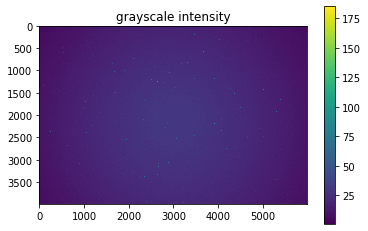

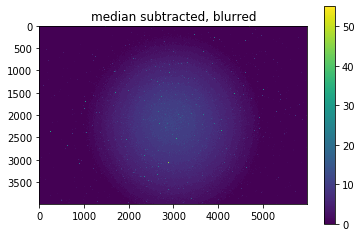

number of stars: 106


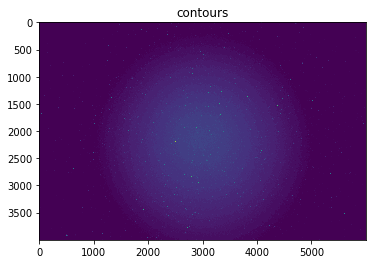

starcoords shape (106, 2)
[[1996.88235294 3958.44117647]
 [ 674.15789474 3907.26315789]
 [ 511.36734694 3913.20408163]
 [3765.         3793.5       ]
 [2725.77777778 3768.5       ]
 [4327.5        3754.61111111]
 [2896.5        3669.6       ]
 [3130.58333333 3649.45833333]
 [2754.5        3577.64285714]
 [2814.         3536.        ]
 [5603.84615385 3510.30769231]
 [1916.05555556 3438.5       ]
 [2682.16       3424.68      ]
 [2359.55555556 3389.        ]
 [2655.15384615 3339.23076923]
 [3172.2        3289.26666667]
 [1286.69565217 3284.82608696]
 [4330.66666667 3266.66666667]
 [4123.84210526 3258.84210526]
 [2483.42857143 3168.85714286]
 [2899.76666667 3073.5       ]
 [2566.54166667 2991.33333333]
 [2929.2        2944.72      ]
 [1980.         2928.        ]
 [2356.58333333 2916.5       ]
 [2798.36111111 2828.69444444]
 [2673.         2798.33333333]
 [4417.14285714 2753.14285714]
 [ 289.78947368 2729.73684211]
 [3042.86666667 2719.66666667]
 [1321.78947368 2704.73684211]
 [3204.      

In [64]:

#load image, convert to grayscale
img = cv2.cvtColor(imgs[0], cv2.COLOR_RGB2GRAY)
plt.imshow(img)
plt.colorbar()
plt.title("grayscale intensity")
plt.show()

#remove light pollution
img = cv2.subtract(img, np.median(img))

#reduce effect of single pixels and non-prominent stars
img = cv2.GaussianBlur(img, (0,0), 3)
plt.imshow(img)
plt.colorbar()
plt.title("median subtracted, blurred")
plt.show()
imgStd = np.std(img)

#create binary mask of star blobs
starMask = np.zeros_like(img)
thresh = imgStd * 8 
starBlobs = img > thresh
starMask[starBlobs] = 1

#get contours, and condense them to single points
contours, hierarchy = cv2.findContours(starMask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE)
print("number of stars:", len(contours))
imgCountours = cv2.drawContours(imgs[0], contours, -1, (255,0,0), thickness=cv2.FILLED)

#get each star location from average position of blob perimeter
starCoords = np.zeros((len(contours), 2))
for c in range(len(contours)):
    starCoords[c, :] = np.mean(contours[c], axis=0)[0]

